In [52]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [34]:
spark = SparkSession.builder.appName("LogisticRegressionBollywood").getOrCreate()

In [35]:
data = spark.read.csv("diabetes_prediction_dataset.csv", header=True, inferSchema=True)

In [36]:
target_col = "diabetes"
data = data.drop("gender")
data = data.drop("smoking_history")
feature_cols = [col for col in data.columns if col != target_col]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

data = vector_assembler.transform(data)

train_data, test_data = data.randomSplit([0.7, 0.3], seed=123)

In [37]:
nb = NaiveBayes(labelCol=target_col, featuresCol="features")
model = nb.fit(train_data)

predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="accuracy"
)

In [49]:
s=[]
for i in range(1,10):
    
    train1, test1 = data.randomSplit([i/10, 1-(i/10)], seed=123)

    nb1 = NaiveBayes(labelCol=target_col, featuresCol="features")
    model1 = nb1.fit(train_data)
    predictions1 = model1.transform(test1)

    evaluator1 = MulticlassClassificationEvaluator(
        labelCol=target_col, predictionCol="prediction", metricName="accuracy"
    )
    accuracy1 = evaluator1.evaluate(predictions1)
    s.append(accuracy1)

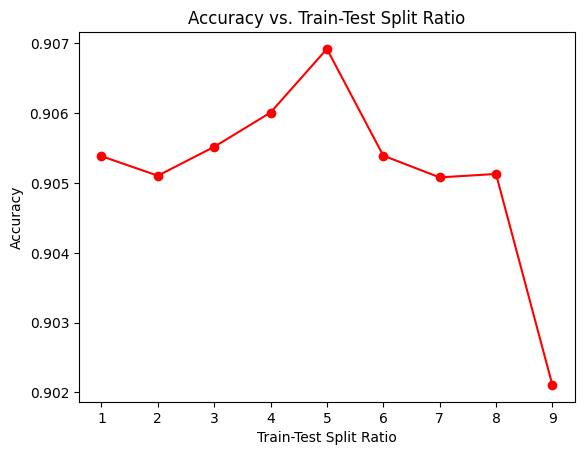

In [55]:
plt.plot(range(1, 10), s, marker='o',color = 'red')
plt.title('Accuracy vs. Train-Test Split Ratio')
plt.xlabel('Train-Test Split Ratio')
plt.ylabel('Accuracy')
plt.show()

In [40]:
accuracy = evaluator.evaluate(predictions)
tp = predictions.filter("diabetes = 1 AND prediction = 1").count()
fp = predictions.filter("diabetes = 0 AND prediction = 1").count()
tn = predictions.filter("diabetes = 0 AND prediction = 0").count()
fn = predictions.filter("diabetes = 1 AND prediction = 0").count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.9021076815502946
Precision: 0.38656987295825773
Recall: 0.24912280701754386
F1 Score: 0.3029871977240398


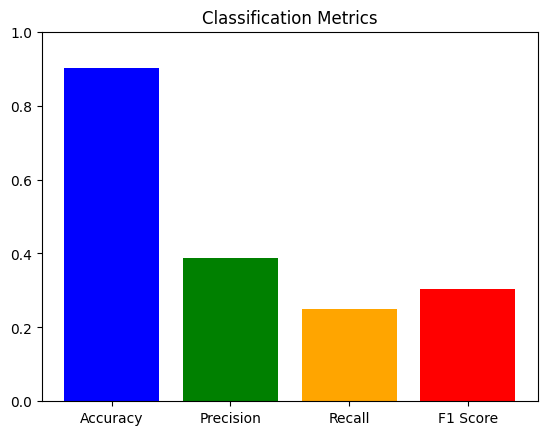

In [56]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

plt.bar(labels, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.title('Classification Metrics')
plt.show()

In [41]:
predictions = model.transform(test_data)
predictions.show(10)

+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+--------------------+--------------------+----------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|       rawPrediction|         probability|prediction|
+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+--------------------+--------------------+----------+
|0.08|           0|            0|11.88|        5.7|                 80|       0|[0.08,0.0,0.0,11....|[-79.993180884092...|[0.97398887351382...|       0.0|
|0.08|           0|            0|12.29|        5.8|                140|       0|[0.08,0.0,0.0,12....|[-107.35198865633...|[0.92440819801384...|       0.0|
|0.08|           0|            0|12.77|        4.5|                160|       0|[0.08,0.0,0.0,12....|[-112.31780486904...|[0.88555346638723...|       0.0|
|0.08|           0|            0|12.89|        6.5|                145

In [53]:
prediction_and_label = predictions.select("prediction", target_col).rdd.map(lambda row: (float(row.prediction), float(row[target_col])))

metrics = MulticlassMetrics(prediction_and_label)

confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:")
print(confusion_matrix)

C:\Users\blruc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[8818.  338.]
 [ 642.  213.]]


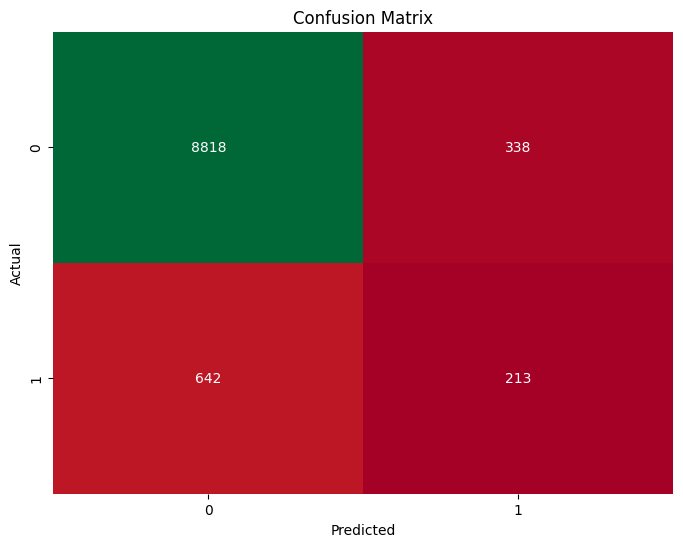

In [54]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap=sns.color_palette("RdYlGn", as_cmap=True), cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [32]:
spark.stop()